In [1]:
!pip install -q pytorch-lightning

## Loading datasets and creating callback

In [2]:
import torch
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
#import model
from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import pytorch_lightning as pl
import torch.nn.functional as F
matplotlib.style.use('ggplot')

In [3]:
batch_size = 64
# transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])
# train and validation data
train_data = datasets.MNIST(
    root='../input/data',
    train=True,
    download=True,
    transform=transform
)
val_data = datasets.MNIST(
    root='../input/data',
    train=False,
    download=True,
    transform=transform
)
# training and validation data loaders
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False
)

In [4]:
import numpy as np
from matplotlib.pyplot import figure, imshow, axis
class PlotSamples(pl.Callback):

    def __init__(self,num_samples,val_samples):

      super().__init__()
      self.num_samples = num_samples
      self.val_samples = val_samples
    
    def on_train_epoch_end(self, trainer, pl_module,x):

        if pl_module.current_epoch % 25 == 0:
          print("Epoch NO: ",pl_module.current_epoch)
         
          # Bring the tensors to CPU
          val_samples = self.val_samples.to(device=pl_module.device)
          rec_imgs = pl_module(val_samples).detach().cpu().numpy()
          rec_samples = rec_imgs.reshape((self.num_samples,28,28))

          val_samples = val_samples.detach().cpu().numpy()
          val_samples = val_samples.reshape((self.num_samples,28,28))

          fig = figure(figsize=(20,10))
          for i in range(self.num_samples):

            a=fig.add_subplot(1,self.num_samples,i+1)
            imshow(val_samples[i],cmap='Greys_r')
            b = fig.add_subplot(2,self.num_samples,i+1)
            imshow(rec_samples[i],cmap='Greys_r')
            axis('off')
          
          plt.show()
idx = np.random.choice(len(train_data),size=(8))
val_imgs = [train_data[i][0] for i in idx]
val_imgs = torch.stack(val_imgs)


plot_samples = PlotSamples(val_imgs.size(0),val_imgs)


## Model definition + Training

In [5]:
features = 16
n_epochs = 30
# define a simple linear VAE
class LinearVAE(pl.LightningModule):
    def __init__(self):
        super(LinearVAE, self).__init__()
 
        # encoder
        self.enc1 = nn.Linear(in_features=784, out_features=512)
        self.enc2 = nn.Linear(in_features=512, out_features=features*2)
 
        # decoder 
        self.dec1 = nn.Linear(in_features=features, out_features=512)
        self.dec2 = nn.Linear(in_features=512, out_features=784)
        self.criterion = nn.BCELoss(reduction='sum')

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
 
    def forward(self, data):
      
        x= data        
        # encoding
        x = x.view(x.size(0),-1)
        x = F.relu(self.enc1(x))
        x = self.enc2(x).view(-1, 2, features)

        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance

        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
 
        # decoding
        x = F.relu(self.dec1(z))
        reconstruction = torch.sigmoid(self.dec2(x))
        return reconstruction
    
    def training_step(self, batch, batch_idx):

      x,y = batch 

      

      x_o = x.view(x.size(0), -1)
      

      # encoding
      x = F.relu(self.enc1(x_o))
      x = self.enc2(x).view(-1, 2, features)

      # get `mu` and `log_var`
      mu = x[:, 0, :] # the first feature values as mean
      logvar = x[:, 1, :] # the other feature values as variance

      # get the latent vector through reparameterization
      z = self.reparameterize(mu, logvar)

      # decoding
      x = F.relu(self.dec1(z))
      reconstruction = torch.sigmoid(self.dec2(x))

      
      bce_loss = self.criterion(reconstruction,x_o)

      BCE = bce_loss 
      KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

      loss = BCE + KLD

      return loss

    def configure_optimizers(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
      return optimizer


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | enc1      | Linear  | 401 K 
1 | enc2      | Linear  | 16.4 K
2 | dec1      | Linear  | 8.7 K 
3 | dec2      | Linear  | 402 K 
4 | criterion | BCELoss | 0     
--------------------------------------
829 K     Trainable params
0         Non-trainable params
829 K     Total params
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: You requested to overfit but enabled training dataloader shuffling. We are turning it off for you.
  warnings.warn(*args, **kwargs)


Epoch NO:  80


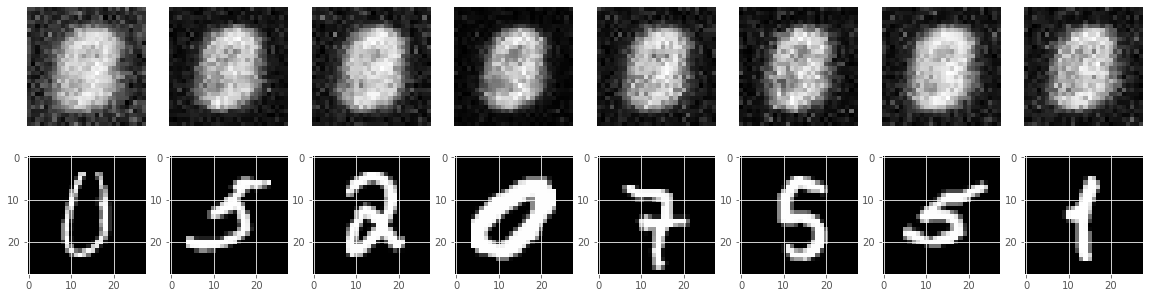

Epoch NO:  80


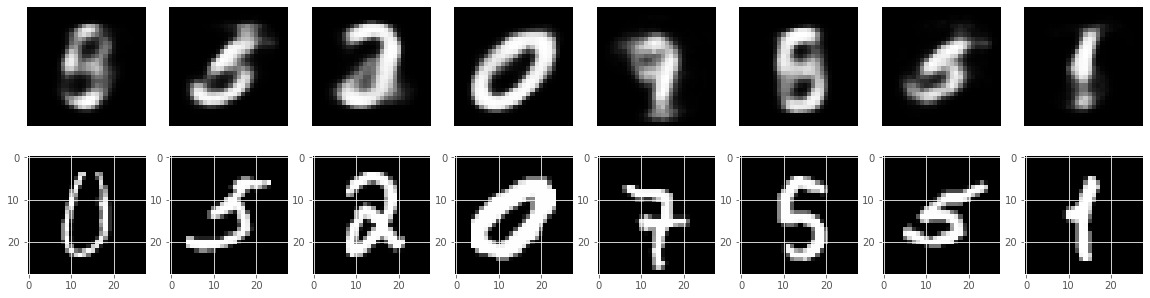

1

In [6]:
autoencoder = LinearVAE()
trainer = pl.Trainer(gpus=1,max_epochs=n_epochs,callbacks=[plot_samples],overfit_batches=0.1)
trainer.fit(autoencoder, train_loader)

## UNET like VAE


In [7]:
FACTOR = 2
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(FACTOR),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=FACTOR, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
  

In [8]:
""" Full assembly of the parts to form the complete network """

import torch.nn.functional as F


class ConvVAE(pl.LightningModule):
    def __init__(self, n_channels, bilinear=True):
        super().__init__()
        self.n_channels = n_channels
        self.bilinear = bilinear
        self.criterion = nn.BCELoss(reduction='sum')

        self.inc = DoubleConv(n_channels, 8)
        self.down1 = Down(8, 16)
        self.down2 = Down(16, 32)
        
        factor = 2 if bilinear else 1
        self.down3 = Down(32,20)

        self.up1 = Up((20 + 32) // 2 , 25 , bilinear)
        self.up2 = Up( 25 + 16 //2 , 25, bilinear)
        self.up3 = Up(25  +  8 //2, 25, bilinear)
        self.outc = OutConv(25, 1)
    
    def reparameterize(self, mu, log_var):
      """
      :param mu: mean from the encoder's latent space
      :param log_var: log variance from the encoder's latent space
      """
      std = torch.exp(0.5*log_var) # standard deviation
      eps = torch.randn_like(std) # `randn_like` as we need the same size
      sample = mu + (eps * std) # sampling as if coming from the input space
      return sample

    
    def forward(self, x,train=False):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)


        
        ### Instead of of passing image we pass a modified version :
        L  = [x1,x2,x3,x4]
        mus,log_vars,samples = [],[],[]

        #### We sample at each scale
        for enc in L:
          split = enc.size(1) //2
          mu = enc[:,:split,:]
          log_var = enc[:,split:,:]
          samples.append(self.reparameterize(mu,log_var))
          mus.append (mu)
          log_vars.append(log_var)
          
          
        

        x_rec = self.up1(samples[-1], samples[-2])
        x_rec = self.up2(x_rec, samples[-3])
        x_rec = self.up3(x_rec, samples[-4])
        x_hat = torch.sigmoid(self.outc(x_rec))
        
        if train: return x_hat,mus,log_vars

        else    : 
          return x_hat
    

    def training_step(self, batch, batch_idx):
        # training_step defined the train loop. It is independent of forward    
        x, y = batch
        x_hat,mu,log_var= self.forward(x,train=True)

        BCE = self.criterion(x_hat,x)
        KLD =0
        ## Sum KL divergence penalty across all scales.
        for m,l in zip(mu,log_var):
          KLD += -0.5 * torch.sum(1 + l - m.pow(2) - l.exp())
        
        loss = BCE + KLD
        self.log('train_loss', loss)
        return loss 
         
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
      

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | BCELoss    | 0     
1 | inc       | DoubleConv | 696   
2 | down1     | Down       | 3.6 K 
3 | down2     | Down       | 14.0 K
4 | down3     | Down       | 9.5 K 
5 | up1       | Up         | 6.1 K 
6 | up2       | Up         | 8.5 K 
7 | up3       | Up         | 6.9 K 
8 | outc      | OutConv    | 26    
-----------------------------------------
49.2 K    Trainable params
0         Non-trainable params
49.2 K    Total params
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWa

Epoch NO:  80


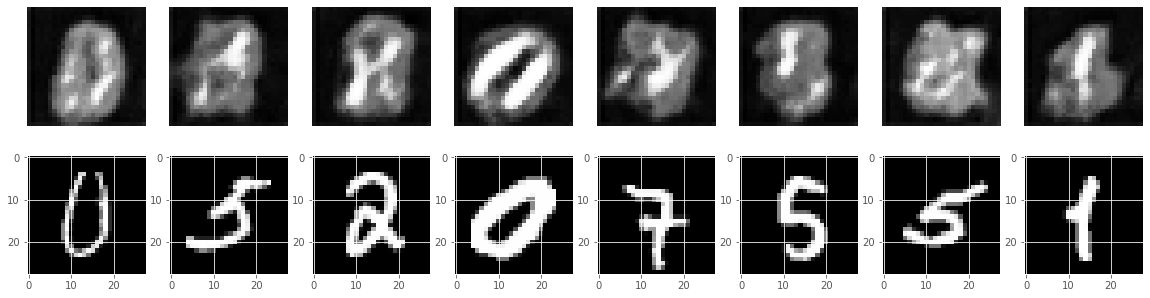

Epoch NO:  80


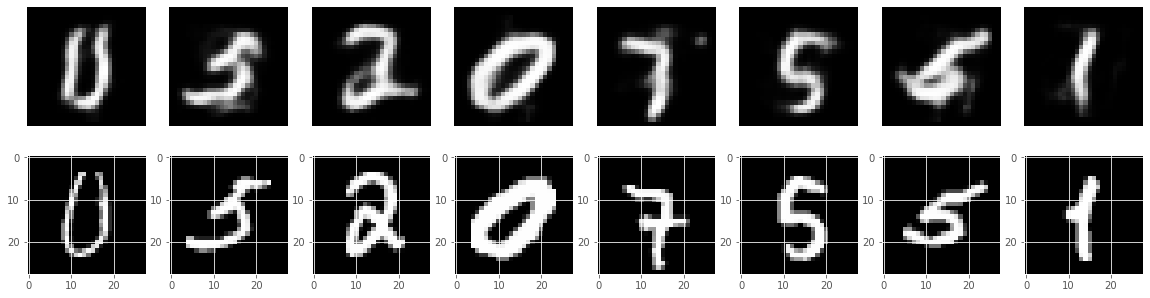

1

In [9]:
autoencoder = ConvVAE(1)
trainer = pl.Trainer(gpus=1,max_epochs=n_epochs,callbacks=[plot_samples],overfit_batches=0.1)
trainer.fit(autoencoder, train_loader)